<a href="https://colab.research.google.com/github/lucywowen/csci591_CCN/blob/main/hackathons/Tutorial2_MBMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational modeling of goal-directed and habitual reinforcement-learning strategies

Adapted from
Claire Smid<sup>1</sup> and Wouter Kool<sup>2</sup><br>
<sub><sup>1</sup> University College London<br>
<sup>2</sup> Washington University in St. Louis<br></sub>

### Workshop Step 2: Goal and Purpose

In the last section, you successfully implemented a model-free learner that performs our two-step task. Here, we will insert a model-based decision maker into this function. At the same time, we will add a 'weighting' parameter that lets us simulate fully model-free agents, fully model-based agents, and anything in between. As we saw before, humans perform tasks like this with a mixture of model-free and model-based control, so in this workbook, we will be getting closer to actually simulating _human behavior_.

# Section 2: model-based reinforcement learning
## The two-step task
Quick reminder: each trial of our two-step task starts in one of two 'first-stage states', that both offer a choice between a pair of spaceships. For each pair, one spaceship will always lead to the red planet, and the other always to the purple planet. Here is the task structure once again:

<p align="center">
  <img src="
https://github.com/ClaireSmid/Model-free_Model-based_Workshop/blob/main/Figures/task_structure_MFMB.png?raw=true" width="650" />
</p>
_Stimuli adapted from Decker et al. 2016_

### Model-free vs model-based reinforcement learning
In the first script, we talked about the distinction between model-free and model-based reinforcement learning.

The key characteristic of a model-based decision maker is that they use the structure of the environment to _plan towards goals_. They use their knowledge of how spaceships transition to planets to infer the expected value of each spaceship. A model-free agent on the other, as you know well, only learns throughs simple action-outcome association.

In other words, this means that model-based agents can transfer experiences obtained after one pair of spaceships to the other pair, but model-free agents can not.

This difference becomes explicitly clear in the graphs below. These depict the probability that an agent revisits the same planet as on the previous trial ('stay' probability) as a function of (1) whether or not a reward was received on that trial and (2) whether the starting state is the same. As you can see, the model-based agent (middle panel) is unaffected by which first-stage state it encounters. It simply goes to a planet if it earned reward there on the previous trial, regardless of the starting state is the same. The model-free learner (left panel), on the other hand, is only more likely to revisit the same second-stage state if it encounters the same pair of rockets.

As we mentioned before, humans display a mixture of both strategies (third panel). Let's write a computational model that is able to capture this type of behavior.

<p align="center">
  <img src="
https://github.com/ClaireSmid/Model-free_Model-based_Workshop/blob/main/Figures/Doll2015_edited_plots_color.jpg?raw=true" width="650" />
</p>
_Edited from Doll et al. 2015_

## Simulating a mixture of model-based and model-free behavior on the two-step task
We will achieve this in a few steps. First, we will copy the softmax and temporal difference learning rules from the last workbook.

More importantly, we will then insert a model-based decision maker in the simulation code. It will use the transition structure to compute an expected value for all actions (spaceships) in the current first-stage state.

Finally, we will use mixture parameter $w$ in this model to calculate a weighted combination of model-based and model-free values in the first-stage state, and then let the agent decide use this combination of Q-values.

With this function, we are hoping to replicate the model-based panel in the middle, as well as the mixture panel on the right. It looks like they would behave quite differently. Let's see this for ourselves!


In [1]:
# first, we'll import some packages that we'll use
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

### Step 1. Drifting reward probabilities
Just as like in the previous script, we are going to generate drifting reward probabilities in the same way. You can run this script as is (it is identical to the code in the first script).

In [2]:
# Create drifting reward rates
def generate_rewards(n_trials, bounds, init_vals, drift_rate):

    # pre-allocate the rest
    reward_probs = np.ones((n_trials, 2)) * 0.5

    # To start with, we initialise one planet lower than the other
    reward_probs[0,:] = random.sample( init_vals, len(init_vals))

    # next, we loop through the trials, and add Gaussian noise to each planet's reward probability for each trial separately
    for t in np.arange(n_trials-1)+1:

        for state in range(2):

            upd = np.random.normal(0, drift_rate) # random Gaussian noise

            reward_probs[t, state] = reward_probs[t-1, state] + upd

            # reflecting bounds
            reward_probs[t, state] = min(reward_probs[t, state],max(bounds[1]*2-reward_probs[t, state],bounds[0]))
            reward_probs[t, state] = max(reward_probs[t, state],min(bounds[0]*2-reward_probs[t, state],bounds[1]))

    return reward_probs

### Step 2. Choice and update results
Same as previously, we are going to write out the softmax function and the temporal difference updating rule. To save time, just copy and paste your final functions from the last script here!

#### First, write out the softmax rule as you wrote it previously.

You can copy-paste your previous softmax rule here

In [3]:
def softmax(Q,beta):

    p = np.exp(beta*Q) / np.sum(np.exp(beta*Q))

    return p # here we return the computed reward probabilities

#### Second, let's write out the temporal difference updating rule
Write out (or copy-paste) your temporal difference updating rule again like you did in the previous section

In [4]:
def td_rule(alpha, Q_chosen, PE):

    Q_chosen_updated = Q_chosen + alpha * PE

    return Q_chosen_updated



### How exactly does model-based learning work?

Perhaps, you feel a bit intimidated by the term "model-based control". It sounds like it will be pretty complicated, and difficult to code. However, it turns out that model-based control in this task is pretty straightforward. To see this, we are first going to guide you through an example, without any programming, so you can get a good intuition!

Imagine that an agent has been playing the task in the diagram already, and that it has learned some model-free values for each spaceship and for each alien. These model-free values are given in the diagram as well. (We are assuming that model-free learning always happens, regardless of whether each decision is more model-based or more model-free.)

Given this state of the learner, an agent can make choices in (a) the left or the right first-stage state, and (b) it can do this using either the first-stage model-free values or calculate model-based values online.



### Step 3. Simulating model-based behavior on the two-step task
Now, we finally get to code up a version of model-based control! Hurray! Even though this may sound a bit daunting, you will soon discover that you have done most of the work already. On each trial the agent will (a) compute compute model-based values for the spaceships in the current first-stage state and then (b) 'mix' those with the existing model-free values in order to choose an action based on this mixture.

#### Model-based calculations
To include a model-based controller, you should add lines of code at the start of each trial that calculate the model-based values (<code>Qmb</code>) of the available space ships _on the fly_. This means that on each trial the model-based system will think about the alien that each space ship visits, and then it will use the value of this alien as the expected, model-based, value of choosing that space ship. (Just like you did in the example above.)

#### Mixture model
In the next step, you will combine these model-based values with the already available first-stage model-free values. Specifically, you will compute a _weighted_ mixture of these values according to a mixture parameter <code>w</code>. This mixing weight needs to be provided as an input parameter for the <code>mb_mf_agent</code> function below, alongside the learning rate <code>alpha</code> and the inverse temperature <code>beta</code>.

In a single line of code, you will mix these two sets of Q-values into a variable called <code>Qnet</code>. You need to do this in such a way that when <code>w=0</code> the agent is fully model-free and <code>Qnet</code> is identical to <code>Qmf1</code>. In contrast, when <code>w=1</code> the agent is fully model-free and <code>Qnet</code> is identical to <code>Qmb</code>. More importantly, w should be able to take on any value between 0 and 1, and therefore it will describe a _spectrum_ of control strategies, ranging from fully model-free to fully model-based and everything in between. This is going to require some thinking on your end!

**Moreover, you should rewrite your code so that the agent uses <code>Qnet</code> (and not just Qmf1) to make its decision at the first stage.**

#### Let's get to it!
In the section below, you will have to finish a function with both a model-free and a model-based agent. However, this will be mostly copying your work from the previous notebook straight into this one. Nothing will change to the updating of model-free values for any of the states, how the transitions occur, or how the rewards are generated.

All the new code will occur after the first-stage state is randomly drawn and before the first-stage cohice is realized. We provide some more hints in the comments.

In the end, your completed code will be able to simulate the behaviour of humans performing this task -- like a mixture of habitual and goal-directed strategies. We again provide code below for you test your work, and plot its behavior.

After you finish this code, you will investigate the differences between model-free and model-based performance. Does model-based control pay off? Next, you will start to investigate whether it is always more accurate, or whether there are some settings in which it underperforms.

In the section below, you can use your knowledge about the temporal difference updating rule and the softmax function and the model-free model to complete the model-based agent's code. The completed code will simulate behaviour of a model-based agent on the task, which we can then plot afterwards and compare to our plots above.

Some things to keep in mind:
- You need to include the 'w' parameter which acts as a mixing weight
- Use the toy example above to implement *model-based* control.
- Use Qnet to make the decision at the first stage

In [ ]:
# we will use a for loop, and generate choices for the agent as they go through the trials and
# learn from rewards

def mb_mf_agent(n_trials, alpha, beta, w):

    # We'll use your generate_rewards function to generate drifting reward probabilities
    bounds = [0, 1]
    init_vals = [0.4, 0.6]
    drift_rate = 0.2
    reward_probs = generate_rewards(n_trials, bounds, init_vals, drift_rate)

    # pre-allocate empty arrays for the data (in chronological order)

    # from previous trial
    prev_rews = np.zeros(n_trials) # this will log the rewards won on the previous trial (i-1)

    # first stage (spaceships)
    first_stage_state = np.zeros(n_trials) # this will log which spaceship pair the participants saw
    state_sim = np.zeros(n_trials) # this will log whether participants saw the same spaceship pair, or the other one
    choices = np.zeros(n_trials) # which rocket the participants chose

    # second stage (planet)
    second_stage_state = np.zeros(n_trials) # this will log which planet the participants transitioned to
    stay = np.zeros(n_trials) # whether participants repeated their transition to the same planet, or not
    rewards = np.zeros(n_trials) # this will log how many rewards the participants won on this trial

    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5

    # Initialise model-free values for the planets
    Qmf2 = np.full(2, 0.5)

    # Initialise model-based values
    Qmb = np.full(2, 0.5)

    # Now, we loop through the trials, making choices
    for i, reward_prob in enumerate(reward_probs):

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = np.random.choice([0, 1])

        # calculate model-based q-values - fill these in
        # note that Qmb just reflects the MB values of the currently available actions.
        # remove: They are calculated online, so there is no updating necessary
        Qmb[0] =                         #--- Fill this in
        Qmb[1] =                         #--- Fill this in

        # mix the two sets of Q-values here with the mixing weight (remember that when w = 0, only the model-free
        # q-values matter, while when w = 1, only the model-based values are taken into account)
        Qnet =                           #--- Fill this in

        # Agent makes a choice using softmax
        p =                              #--- Fill this in


        ### the code below will be identical to the model in Step1

        # Make a weighted choice using the np.random.choice function and the variable p (you can use help(function)
        # to find out more) (identical to first model)
        choice =                                           #--- Copy from function in Step 1

        # Make the transition to the planet
        s2 =                                               #--- Copy from function in Step 1

        # Calculate first prediction error (no reward here)
        pe_1 =                                             #--- Copy from function in Step 1

        # update choice
        Qmf1[s1,choice] =                                  #--- Copy from function in Step 1

        # Agent receives a reward (1 or 0) (depending on reward probability)
        r =                                                #--- Copy from function in Step 1

        # Calculate second prediction error (actual reward)
        pe_2 =                                             #--- Copy from function in Step 1

        # update value of alien (planet)
        Qmf2[s2] =                                         #--- Copy from function in Step 1

        # update value of choice (spaceship)
        Qmf1[s1,choice] =                                  #--- Copy from function in Step 1


        # save data from this trial to our pre-allocated arrays
        rewards[i] = r
        first_stage_state[i] = s1
        second_stage_state[i] = s2

        # these are based on the previous trial (i-1)
        if i != 0: # start at second trial (first trial this is set to 0)
            # whether they transitioned to the same planet on this trial
            if s2 == second_stage_state[i-1]:
                stay[i] = 1
            # whether they saw the same spaceship pair on this trial
            if s1 == first_stage_state[i-1]:
                state_sim[i] = 1
            # whether they received a reward on the previous trial
            prev_rews[i] = rewards[i-1]


        # you can uncomment the lines below to see what happens each trial in printed form.
        # note that if you uncomment these, the figure in the cell below will print all the way
        # at the bottom of the printed statements (just comment the lines out again to see figure immediately)

#         ###   comment code between this this out or in (shortcut = ctrl + /)

#        # print spaceship choice and which pair was seen
#        # spaceship chosen
#         if choice == 0:
#             position = 'left'
#         else:
#             position = 'right'

#         print(f'trial: {i+1}, rocket pair: {s1+1}, spaceship chosen: {position}')

#         # print which planet was transitioned to
#         if s2 == 0:
#             color = 'red'
#         else:
#             color = 'purple'

#         print(f'transitioned to {color} planet, first prediction error: {pe_1}')
#         print(f'stay: {bool(stay[i])}, agent received: {r}')
#         print(f'{color} planet prediction error: {pe_2}')
#         print(f'Model-free q-values for spaceships:\n[1:left, 1:right,\n2:left, 2:right]\n{Qmf1}')
#         print(f'Model-free q-values for aliens/planets:\n[red, purple]\n{Qmf2}')
#         print(f'Model-based q-values for spaceships:\n{Qmb}') # this is now 2 values
#         print(f'Qnet for planets\n[red, purple]\n{Qnet}\n')

#         ###   comment code between this out or in


    # data returned by function
    return stay, state_sim, prev_rews, rewards


SyntaxError: invalid syntax (<ipython-input-7-a40d8f03e985>, line 45)

In [ ]:
# we will use a for loop, and generate choices for the agent as they go through the trials and
# learn from rewards

def mb_mf_agent(n_trials, alpha, beta, w):

    # We'll use your generate_rewards function to generate drifting reward probabilities
    bounds = [0, 1]
    init_vals = [0.4, 0.6]
    drift_rate = 0.2
    reward_probs = generate_rewards(n_trials, bounds, init_vals, drift_rate)

    # pre-allocate empty arrays for the data (in chronological order)

    # from previous trial
    prev_rews = np.zeros(n_trials) # this will log the rewards won on the previous trial (i-1)

    # first stage (spaceships)
    first_stage_state = np.zeros(n_trials) # this will log which spaceship pair the participants saw
    state_sim = np.zeros(n_trials) # this will log whether participants saw the same spaceship pair, or the other one
    choices = np.zeros(n_trials) # which rocket the participants chose

    # second stage (planet)
    second_stage_state = np.zeros(n_trials) # this will log which planet the participants transitioned to
    stay = np.zeros(n_trials) # whether participants repeated their transition to the same planet, or not
    rewards = np.zeros(n_trials) # this will log how many rewards the participants won on this trial

    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5

    # Initialise model-free values for the planets
    Qmf2 = np.full(2, 0.5)

    # Initialise model-based values
    Qmb = np.full(2, 0.5)

    # Now, we loop through the trials, making choices
    for i, reward_prob in enumerate(reward_probs):

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = np.random.choice([0, 1])

        # calculate model-based q-values - fill these in
        # note that Qmb just reflects the MB values of the currently available actions.
        # remove: They are calculated online, so there is no updating necessary
        Qmb[0] = Qmf2[0]                                #--- Fill this in
        Qmb[1] = Qmf2[1]                                #--- Fill this in

        # mix the two sets of Q-values here with the mixing weight (remember that when w = 0, only the model-free
        # q-values matter, while when w = 1, only the model-based values are taken into account)
        Qnet = w * Qmb + (1-w) * Qmf1[s1]               #--- Fill this in

        # Agent makes a choice using softmax
        p = softmax(Qnet, beta)                         #--- Fill this in


        ### the code below will be identical to the model in Step1

        # Make a weighted choice using the np.random.choice function and the variable p (you can use help(function)
        # to find out more) (identical to first model)
        choice = int(np.random.uniform(0,1) > p[0])

        # Make the transition to the planet
        s2 = choice # transition to the right planet

        # Calculate first prediction error (no reward here)
        pe_1 = Qmf2[s2] - Qmf1[s1,choice] # calculate the first pe

        # update choice
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_1) # finish this with the td rule

        # Agent receives a reward (1 or 0) (depending on reward probability)
        r = int(np.random.uniform(0,1) < reward_probs[i,s2])

        # Calculate second prediction error (actual reward)
        pe_2 = r - Qmf2[s2]    # Finish this to calculate the second pe

        # update value of alien (planet)
        Qmf2[s2] = td_rule(alpha, Qmf2[s2], pe_2) # finish this with the td rule for the alien

        # update value of choice (spaceship)
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_2) # finish this with the td rule for the spaceship choice

        # save data from this trial to our pre-allocated arrays
        rewards[i] = r
        first_stage_state[i] = s1
        second_stage_state[i] = s2

        # these are based on the previous trial (i-1)
        if i != 0: # start at second trial (first trial this is set to 0)
            # whether they transitioned to the same planet on this trial
            if s2 == second_stage_state[i-1]:
                stay[i] = 1
            # whether they saw the same spaceship pair on this trial
            if s1 == first_stage_state[i-1]:
                state_sim[i] = 1
            # whether they received a reward on the previous trial
            prev_rews[i] = rewards[i-1]


        # you can uncomment the lines below to see what happens each trial in printed form.
        # note that if you uncomment these, the figure in the cell below will print all the way
        # at the bottom of the printed statements (just comment the lines out again to see figure immediately)

#         ###   comment code between this this out or in (shortcut = ctrl + /)

#        # print spaceship choice and which pair was seen
#        # spaceship chosen
#         if choice == 0:
#             position = 'left'
#         else:
#             position = 'right'

#         print(f'trial: {i+1}, rocket pair: {s1+1}, spaceship chosen: {position}')

#         # print which planet was transitioned to
#         if s2 == 0:
#             color = 'red'
#         else:
#             color = 'purple'

#         print(f'transitioned to {color} planet, first prediction error: {pe_1}')
#         print(f'stay: {bool(stay[i])}, agent received: {r}')
#         print(f'{color} planet prediction error: {pe_2}')
#         print(f'Model-free q-values for spaceships:\n[1:left, 1:right,\n2:left, 2:right]\n{Qmf1}')
#         print(f'Model-free q-values for aliens/planets:\n[red, purple]\n{Qmf2}')
#         print(f'Model-based q-values for spaceships:\n{Qmb}') # this is now 2 values
#         print(f'Qnet for planets\n[red, purple]\n{Qnet}\n')

#         ###   comment code between this out or in


    # data returned by function
    return stay, state_sim, prev_rews, rewards

#### Testing the mixture model

In the cell below, you can run the mixture function that you are writing, and you can see if it runs without any errors. If you do run into errors, try to see if you can decipher what might be going wrong from the outputs (and Google). You can also look the solutions (but again, it will be more fulfilling to figure this out yourself).

Note that the code running without any errors does not mean that your code is doing what you _want_ it do. Your code does not know your intentions, and will blissfully execute your commands. There are many ways in which you can write wrong code, without this notebook giving you an error message.

To debug your code, try printing the different choices that the simulated agent makes, and the Q-values for each choice. Are they updating as expected? At the end of the function above, we have provided useful print statements that we commented out. You can uncomment these, and use them to view the output of each trial consecutively to see how things change. Note that you will need to rerun the cell above after any change you make before the code below reflects these changes.

Try to think about the toy example you completed above. Are the model-based (Qmb) values calculated as you expect? What needs to happen here? In addition, are the model-free (Qmf) values still updating as you expect them to?


In [ ]:
# initialise values
n_trials = 200
alpha = 0.5
beta = 4
w = 1

# run an agent
[stay, state_sim, prev_rews, rewards] = mb_mf_agent(n_trials, alpha, beta, w)


#### Plotting new stay probability plots for _w_ = 1 or _w_ = 0
You can run the code below to plot simulated behaviour from your code.

A great way to test would be to set _w_ to 0 or 1, and to view whether this results in the right "stay behavior" as a function of whether a reward was received on the previous trial, and whether the starting state is the same. You can see the example plots of this behavior for a pure model-free and model-based agent below. Is there a qualitative match?

Remember that you can increase the trial size with which you simulate data to see a less "noisy" plot, to help you detemine if you are generating the behavior you expect. You will notice that the plots are quite variable with just 200 trials, but very stable with 20000.

In [ ]:
# Run an agent and plot the data
n_trials = 200
alpha = 0.5
beta = 4
w =             # Fill this in

# to print correct title on plot
if w == 0:
    behave = 'model-free'
elif w == 1:
    behave = 'model-based'
else:
    behave = 'mixture'

[stay, state_sim, prev_rews, rewards] = mb_mf_agent(n_trials, alpha, beta, w)

# calculate probabilities
df = pd.DataFrame({"Rocket_State_Sim":state_sim,"Previous_Rewards":prev_rews,"Stay":stay})
plot_data = df.groupby(["Rocket_State_Sim","Previous_Rewards"]).mean().unstack()
a = plot_data.reset_index()

# plot the graph
fig, ax = plt.subplots()
a.plot(x = "Rocket_State_Sim", kind="bar", ylim = [0,1],
       stacked=False,ax=ax)

# figure legends
ax.legend(["Loss","Win"])
ax.set_ylabel("Stay Probability")
plt.xticks(rotation=1)
ax.set_xticklabels(['Different','Same'])
ax.set_xlabel("Starting State Similarity")
ax.invert_xaxis()

# title corresponding to w value
ax.set_title(f'Simulated {behave} agent', fontweight='bold')

# text bubble for w according to value
ax.text(-0.6,0.9, f'w = {w}', color = 'black', size=12,
       bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle = 'round'))

plt.show()

SyntaxError: invalid syntax (<ipython-input-10-cef9c6577eb6>, line 5)

#### Let's compare these to both the model-free and model-based stay probabilities, and to the behavior from participants on a task like this.


<p align="center">
  <img src="
https://github.com/ClaireSmid/Model-free_Model-based_Workshop/blob/main/Figures/Doll2015_edited_plots_color.jpg?raw=true" width="650" />
</p>
_edited from Doll et al. 2015_

How does the staying behavior change in this task? What do you see when <code>w=0</code>,  <code>w=1</code>, or anywhere in between?

### Comparing performance between model-free and model-based agents.
So, this task can be completed using two different strategies, but it's not clear how those two strategies translate to the amount of earned reward.

To investigate this, the script below will simulate behavior for both a purely model-based agent (w=1) and a purely model-free agent. For both, it will compute the number of trials on which it earned reward. These scores (and their differences) will then be printed. This way, you can test whether the model-based agent does a better job in performing this task than the model-free learner!

Try it out below:

In [ ]:
# Simulate a model-based agent and check performance
n_trials = 200
alpha = 0.5
beta = 4

# simulate a model-based agent and check performance
w = 1

[stay, state_sim, prev_rews, mb_rewards] = mb_mf_agent(n_trials, alpha, beta, w)

# calculate performance
mb_score = sum(mb_rewards)*100 / n_trials
print(f'Model-based performance: {round(mb_score,2)}% of the trials\n')

# Simulate a model-free agent and check performance
# we will use the same values as above, except that we set w to 0
w = 0

[stay, state_sim, prev_rews, mf_rewards] = mb_mf_agent(n_trials, alpha, beta, w)

# calculate performance
mf_score = sum(mf_rewards)*100 / n_trials
print(f'Model-free performance: {round(mf_score,2)}% of the trials\n')


# calculate difference in performance between the model-based and model-free agent
print(f'Model-based increase in performance: {round(mb_score - mf_score,2)}% of the trials\n')


Model-based performance: 52.5% of the trials

Model-free performance: 54.0% of the trials

Model-based increase in performance: -1.5% of the trials



<mark>Try to answer these questions:</mark>
- Does the performance also change with a higher or lower _w_?
- What happens for values of _w_ between 0 and 1?

**Hint**: to see more robust scores, you can increase the number of simulated trials (hopefully this will show you that it is important to have enough trials and participants in your experiments!)


### Well done! You have finished Step 2 of the workshop, amazing work!
If you want to (and we still have time for this script) you can do the extra assignment below. However, Step 3 of the workshop is waiting for you, where we will practice fitting the model to simulated data, and seeing how well our model does at recovering the parameter values (alpha, beta and w) that we use to simulate that data.

<br>

### Extra assignment: tracking the Q-values

We can also plot the Q-values which were generated by this model, same as we did previously, along with the reward probabilities that we generated previously.

If you set _w_ to 1, we can plot only the model-based values, and see if they do a better job than in the previous script!
Which model tracks better? the model-free or model-based one?

We have written the code to generate the plots below this cell. In the cell directly below, you can use the exact same model we used before, only you have to save (return) a few more things:
- Qnet values of the planets for each trial
- True reward probabilities
- The choices the agent made on each trial

**Hint**: This is almost exactly identical to how you did this in the last script, except now we just have a different name for the Q-values (the ones used to make decisions in your mixture agent).

In [ ]:
def mb_mf_agent_Qs(n_trials, alpha, beta, w):

    # We'll use your generate_rewards function to generate drifting reward probabilities
    bounds = [0, 1]
    init_vals = [0.4, 0.6]
    drift_rate = 0.2
    reward_probs = generate_rewards(n_trials, bounds, init_vals, drift_rate)

    # Pre-allocate empty arrays for the data

    choices = np.zeros(n_trials) # which spaceship the participants chose
    rewards = np.zeros(n_trials) # how many rewards the participants won on this trial
    Qnets =                      # what the Q-values are on each trial     #--- Fill this in

    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5

    # Initialise model-free values for the planets
    Qmf2 = np.full(2, 0.5)

    # Initialise model-based values
    Qmb = np.full(2, 0.5)

    # Now, we loop through the trials, making choices
    for i, reward_prob in enumerate(reward_probs):

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = np.random.choice([0, 1])

        ### different:
        # calculate model-based q-values - fill these in
        # note that Qmb just reflects the MB values of the currently available actions.
        # remove: They are calculated online, so there is no updating necessary
        Qmb[0] =                        #--- Copy from your function above
        Qmb[1] =                        #--- Copy from your function above

        ### different:
        # mix the two sets of Q-values here with the mixing weight (remember that when w = 0, only the model-free
        # q-values matter, while when w = 1, only the model-based values are taken into account)
        Qnet =                          #--- Copy from your function above

        ### different:
        # Agent makes a choice using softmax
        p =                             #--- Copy from your function above

        # Make a weighted choice using the np.random.choice function and the variable p (you can use help(function)
        # to find out more) (identical to first model)
        choice = choices[i] =           #--- Copy from your function above (note, we also save choices[i] here)

        # Make the transition to the planet
        s2 =                            #--- Copy from your function above

        # Calculate first prediction error (no reward here)
        pe_1 =                          #--- Copy from your function above

        # update choice
        Qmf1[s1,choice] =               #--- Copy from your function above

        # Agent receives a reward (1 or 0) (depending on reward probability)
        r = int(np.random.uniform(0,1) < reward_probs[i,s2])

        # Calculate second prediction error (actual reward)
        pe_2 =                          #--- Copy from your function above

        # update value of alien (planet)
        Qmf2[s2] =                      #--- Copy from your function above

        # update value of choice (spaceship)
        Qmf1[s1,choice] =               #--- Copy from your function above

        # save q values
        # you need to save 2 q-values for every trial, which are the same q-values as for the second stage (alien/planet)
        Qnets[:,i] = Qnet                                #--- Fill this in


    # data returned by function
    return choices, Qnets, reward_probs

In [ ]:
def mb_mf_agent_Qs(n_trials, alpha, beta, w):

    # We'll use your generate_rewards function to generate drifting reward probabilities
    bounds = [0, 1]
    init_vals = [0.4, 0.6]
    drift_rate = 0.2
    reward_probs = generate_rewards(n_trials, bounds, init_vals, drift_rate)

    # Pre-allocate empty arrays for the data

    choices = np.zeros(n_trials) # which spaceship the participants chose
    rewards = np.zeros(n_trials) # how many rewards the participants won on this trial
    Qnets = np.zeros((2, n_trials)) # what the Q-values are on each trial             #--- Fill this in

    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5

    # Initialise model-free values for the planets
    Qmf2 = np.full(2, 0.5)

    # Initialise model-based values
    Qmb = np.full(2, 0.5)

    # Now, we loop through the trials, making choices
    for i, reward_prob in enumerate(reward_probs):

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = np.random.choice([0, 1])

        ### different:
        # calculate model-based q-values - fill these in
        # note that Qmb just reflects the MB values of the currently available actions.
        # remove: They are calculated online, so there is no updating necessary
        Qmb[0] = Qmf2[0]
        Qmb[1] = Qmf2[1]

        ### different:
        # mix the two sets of Q-values here with the mixing weight (remember that when w = 0, only the model-free
        # q-values matter, while when w = 1, only the model-based values are taken into account)
        Qnet = w * Qmb + (1-w) * Qmf1[s1]

        ### different:
        # Agent makes a choice using softmax
        p = softmax(Qnet, beta) # Fill this in

        # Make a weighted choice using the np.random.choice function and the variable p (you can use help(function)
        # to find out more) (identical to first model)
        choice = choices[i] = int(np.random.uniform(0,1) > p[0])

        # Make the transition to the planet
        s2 = choice # finish this line to transition to the right planet

        # Calculate first prediction error (no reward here)
        pe_1 = Qmf2[s2] - Qmf1[s1,choice] # Finish this to calculate the first pe

        # update choice
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_1) # finish this with the td rule

        # Agent receives a reward (1 or 0) (depending on reward probability)
        r = int(np.random.uniform(0,1) < reward_probs[i,s2])

        # Calculate second prediction error (actual reward)
        pe_2 = r - Qmf2[s2]    # Finish this to calculate the second pe

        # update value of alien (planet)
        Qmf2[s2] = td_rule(alpha, Qmf2[s2], pe_2) # finish this with the td rule for the alien

        # update value of choice (spaceship)
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_2) # finish this with the td rule for the spaceship choice

        # save q values
        # you need to save 2 q-values for every trial, which are the same q-values as for the second stage (alien/planet)
        Qnets[:,i] = Qnet                                #--- Fill this in


    # data returned by function
    return choices, Qnets, reward_probs

Now, we can run the cell below to generate a figure to track the q-values again:

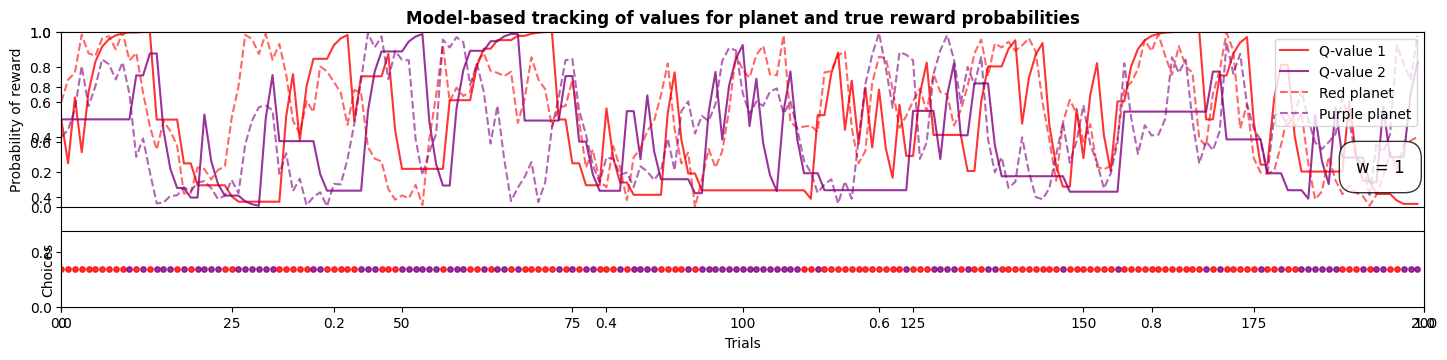

In [ ]:
# we can plot how well this model did at tracking the highest probability of receiving a reward

# set values
n_trials = 200
alpha = 0.5
beta = 4
w = 1

# to print correct title on plot
if w == 0:
    behave = 'Model-free'
elif w == 1:
    behave = 'Model-based'
else:
    behave = 'Mixture'

# run the agent
choices, Qnets, reward_probs = mb_mf_agent_Qs(n_trials, alpha, beta, w)

colors = ['red','purple']

# Define plot sizes
fig, ax = plt.subplots(figsize=(15, 4), facecolor='w')
ax = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=2)

# plot the Q-values
for i, (i, color) in enumerate(zip(range(2), colors)):
    ax.plot(np.arange(n_trials), Qnets[i, :], alpha = 0.8, label = 'Q-value ' + str(i+1), color = color)

# defining some plot stuff
ax.set_ylim(0, 1) # ax.set_ylim(0, 1)
ax.set_xlim(0, n_trials)
ax.set_xticks([])
ax.set_ylabel('Q-values')
ax.legend()

# Overlay reward values
for i, (i, color) in enumerate(zip(range(2), colors)):
    if i == 0:
        label_ = 'Red planet'
    else:
        label_ = 'Purple planet'

    ax.plot(np.arange(n_trials), reward_probs[:,i], alpha = 0.6, linestyle = '--', label = label_, color = color)


# adding some labels and legends
ax.set_ylabel('Probability of reward')

# title corresponding to w value
ax.set_title(f'{behave} tracking of values for planet and true reward probabilities', fontweight='bold')

# text bubble for w according to value
ax.text(190,0.2, f'w = {w}', color = 'black', size=12,
       bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle = 'round,pad=1'))

ax.legend(loc=1)

# plot the choices the agent made (either red or purple planet)
ax = plt.subplot2grid((3, 1), (2, 0), colspan=1, rowspan=1)
for i, choice in enumerate(choices):
    ax.scatter(i, 0, color=colors[int(choice)], s=15, alpha = 0.8)

# defining some plot stuff
ax.set_xlim(0, n_trials)
ax.set_yticks([])
ax.set_xlabel('Trials')
ax.set_ylabel('Choices')

plt.tight_layout()

In the cell above, set <code>w</code> to different values, and inspect the graphs.

<mark>What do you think? Is there a difference in how the Q-values are tracked when the agent is purely model-based compared to when it is purely model-free?</mark>

<mark>How does this exercise help you explain the difference in average reward between the model-based and the model-free decision maker?</mark>

### Well done! You have finished the complete Step 2 of the workshop!
If you want to (and we still have time) feel free to open the next script for Step3, where will practice fitting the model to simulated data, and seeing how well our model does at recovering the parameter values (alpha, beta and w) that we use to simulate that data. This process is called parameter recovery.